In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
data_path = '/content/drive/MyDrive/Class1'

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array, load_img
import os
import glob
import imageio.v3 as iio
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import KFold
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array, load_img
import os

In [ ]:
def load_file(file_path, label):
    file_path =file_path

    folder_name = file_path.split("/")[-1]

    out_list = []

    # Load every file .png format
    for image_path in glob.glob(file_path + "/*.PNG"):
        # Read image file
        image = iio.imread(image_path)

        # Declare temporary dict dtype
        temp = {}

        # Set the file name
        temp["name"] = image_path.split("/")[-1]

        # Set the file label, 0 for non defect. 1 for defect
        temp["label"] = label
        # There are somes images are tensor dtype
        # Thus I fix by selecting only a tensor index zero
        try:
            temp["data"] = image[:,:,0].astype("int")
        except:
            # Normal case
            temp["data"] = image.astype("int")

        # Append temp into output list
        out_list.append(temp)

    # Print process status by checking size of output list
    if len(out_list) == 0:
        print("loading files from folder: {} is   failed".format(folder_name))
    else:
        print("loading file from folder: {} is successful".format(folder_name))

    # Convert list into numpy array dtype
    return np.array(out_list)

In [ ]:
pic = data_path + '/defect/0002.PNG'
im = iio.imread(pic)
print('picture shape: {}'.format(im.shape))
print('picture matrix: \n {}'.format(im))
# Set display size


picture shape: (512, 512)
picture matrix: 
 [[ 64  98  66 ...  65  55 133]
 [106 108 148 ...  45  45  55]
 [125 133 196 ...  62  49 122]
 ...
 [ 76  83 104 ...  54  58  56]
 [ 46  56  75 ...  65  66  90]
 [ 96  38  90 ...  90  90 145]]


In [ ]:
defect_images_path = data_path + '/defect'
non_defect_images_path = data_path + '/non-defect'

defect_images = load_file(defect_images_path, 1)
non_defect_images = load_file(non_defect_images_path, 0)

loading file from folder: defect is successful
loading file from folder: non-defect is successful


In [ ]:
np.random.shuffle(non_defect_images)
np.random.shuffle(defect_images)

#class_size = defect_images.shape[0] if defect_images.shape[0] <= non_defect_images.shape[0] else non_defect_images.shape[0]

dataset = np.concatenate((defect_images, non_defect_images))
# Create an empty matrix X with is matrix of 256x4096
# with row equals dataset's length
X = np.empty([dataset.shape[0], 512, 512]).astype(int)
# Create vector y that has dataset length
y = np.empty(dataset.shape[0]).astype(int)

# Assign the X,y one-by-one
for i in range(dataset.shape[0]):
    X[i] = dataset[i]["data"]
    y[i] = dataset[i]["label"]
# Since Keras acquire the Image input is a tensor type, we reshape X
X = X.reshape(X.shape[0], 512, 512, 1)
# Display size of the label 0 and label 1
np.unique(y, return_counts=True)

<ipython-input-7-20cbcdea9daf>:11: RuntimeWarning: invalid value encountered in cast
  y = np.empty(dataset.shape[0]).astype(int)


(array([0, 1]), array([1068,  150]))

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from keras import layers, models,datasets,  optimizers, regularizers
def create_model(image_shape=(512, 512, 1), print_summary=False):
    # Initial model
    model = models.Sequential()
    # CONV layer: filter 16, stride 7x7
    model.add(layers.Conv2D(16, (7, 7),input_shape=image_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation("relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
    # CONV layer: filter 32, stride 5x5
    model.add(layers.Conv2D(32, (5, 5), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # CONV layer: filter 64, stride 3x3
    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # CONV layer: filter 64, stride 3x3
    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Flatten())

    # Fully connected layer -> nn layer with 64 nodes
    model.add(layers.Dense(64))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.25))
    # Fully connected layer -> nn layer with 64 nodes
    model.add(layers.Dense(64))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.25))

    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))

    # Set model compiler
    model.compile(optimizer="SGD", loss="binary_crossentropy",          metrics=["accuracy"])

    # Show the CNN model detail
    if print_summary:
        model.summary()

    return model

In [ ]:
from keras.callbacks import EarlyStopping

def train_model(model, xtrain, ytrain, xval, yval, n_epoch, batch_size):
    # Train CNN model
    # Batch size to reduce memory usage
    # Set early stopping to avoid overfitting

    earlystopping = EarlyStopping(monitor="val_accuracy", patience=2)
    history = model.fit(xtrain, ytrain, epochs=n_epoch, batch_size=batch_size, validation_data=(xval, yval), callbacks=[earlystopping])
    return history


In [ ]:
from sklearn.model_selection import StratifiedKFold
# Set number of split
kfold_splits = 4
# Set number of epoch
n_epoch = 5
# Set batch size
batch_size = 10
# Create StratifiedKFold
skf = StratifiedKFold(n_splits=kfold_splits, shuffle=True)
for index, (train_indices, val_indices) in enumerate(skf.split(X, y)):
    print('Training on fold {}/{}…'.format(index+1, kfold_splits))

    # Declare x train and x validate
    xtrain, xval = X[train_indices], X[val_indices]
    # Declare y train and y validate
    ytrain, yval = y[train_indices], y[val_indices]
    # Print number of class portion
    print('ytrain: number of samples each class: {}'.format(np.unique(ytrain, return_counts=True)))
    print('yval: number of samples each class: {}'.format(np.unique(yval, return_counts=True)))

    # Clear the model
    model = None
    # Create cnn model
    model = create_model()
    print('Training new iteration on {} training samples, {} validation samples, this may be a while…'.format(xtrain.shape[0], xval.shape[0]))

    # Train CNN model
    history = train_model(model, xtrain, ytrain, xval, yval, n_epoch, batch_size)
    print('— — — — — '*5)

Training on fold 1/4…
ytrain: number of samples each class: (array([0, 1]), array([801, 112]))
yval: number of samples each class: (array([0, 1]), array([267,  38]))
Training new iteration on 913 training samples, 305 validation samples, this may be a while…
Epoch 1/5
92/92 [==============================] - 20s 100ms/step - loss: 0.5310 - accuracy: 0.7514 - val_loss: 0.4602 - val_accuracy: 0.8754
Epoch 2/5
92/92 [==============================] - 6s 70ms/step - loss: 0.3981 - accuracy: 0.8664 - val_loss: 0.4467 - val_accuracy: 0.8754
Epoch 3/5
92/92 [==============================] - 6s 70ms/step - loss: 0.3833 - accuracy: 0.8751 - val_loss: 0.3948 - val_accuracy: 0.8754
— — — — — — — — — — — — — — — — — — — — — — — — — 
Training on fold 2/4…
ytrain: number of samples each class: (array([0, 1]), array([801, 112]))
yval: number of samples each class: (array([0, 1]), array([267,  38]))
Training new iteration on 913 training samples, 305 validation samples, this may be a while…
Epoch 1/5

Validation Accuracy Average: 0.8768499999999999
Validation Loss Average: 0.4056916666666667


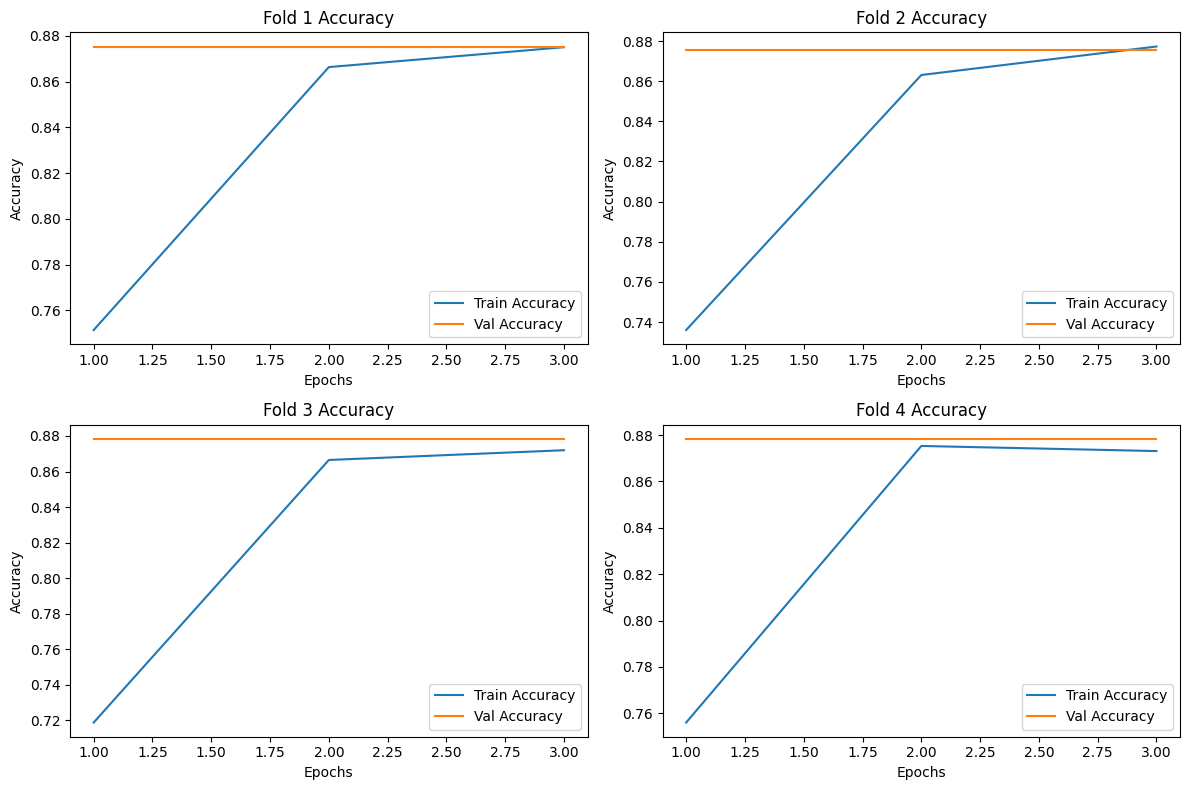

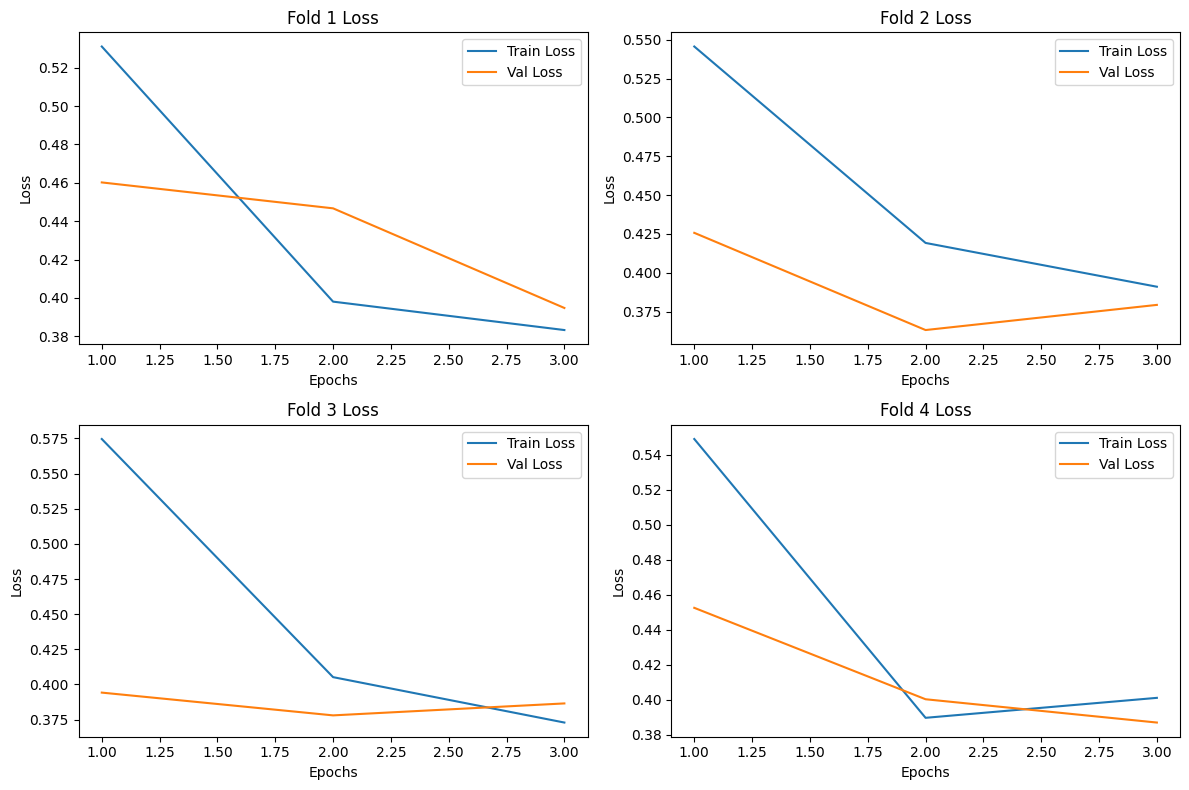

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

# Function to create epochs
def create_epoch(n=0):
    return np.arange(0, n) + 1

# Model evaluation results for each fold
fold1_epoch = create_epoch(n=3)
fold1_loss = np.array([0.5310, 0.3981, 0.3833])
fold1_acc = np.array([0.7514, 0.8664, 0.8751])
fold1_val_loss = np.array([0.4602, 0.4467, 0.3948])
fold1_val_acc = np.array([0.8754, 0.8754, 0.8754])

fold2_epoch = create_epoch(n=3)
fold2_loss = np.array([0.5457, 0.4192, 0.3910])
fold2_acc = np.array([0.7360, 0.8631, 0.8773])
fold2_val_loss = np.array([0.4257, 0.3631, 0.3793])
fold2_val_acc = np.array([0.8754, 0.8754, 0.8754])

fold3_epoch = create_epoch(n=3)
fold3_loss = np.array([0.5746, 0.4052, 0.3729])
fold3_acc = np.array([0.7188, 0.8665, 0.8720])
fold3_val_loss = np.array([0.3942, 0.3780, 0.3865])
fold3_val_acc = np.array([0.8783, 0.8783, 0.8783])

fold4_epoch = create_epoch(n=3)
fold4_loss = np.array([0.5489, 0.3897, 0.4011])
fold4_acc = np.array([0.7560, 0.8753, 0.8731])
fold4_val_loss = np.array([0.4525, 0.4003, 0.3870])
fold4_val_acc = np.array([0.8783, 0.8783, 0.8783])

# Calculate validation averages
val_acc_avg = (np.mean(fold1_val_acc) + np.mean(fold2_val_acc) + np.mean(fold3_val_acc) + np.mean(fold4_val_acc)) / 4
val_loss_avg = (np.mean(fold1_val_loss) + np.mean(fold2_val_loss) + np.mean(fold3_val_loss) + np.mean(fold4_val_loss)) / 4

print("Validation Accuracy Average:", val_acc_avg)
print("Validation Loss Average:", val_loss_avg)

# Plot training and validation accuracy for each fold
plt.figure(figsize=(12, 8))

# Fold 1
plt.subplot(2, 2, 1)
plt.plot(fold1_epoch, fold1_acc, label='Train Accuracy')
plt.plot(fold1_epoch, fold1_val_acc, label='Val Accuracy')
plt.title('Fold 1 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Fold 2
plt.subplot(2, 2, 2)
plt.plot(fold2_epoch, fold2_acc, label='Train Accuracy')
plt.plot(fold2_epoch, fold2_val_acc, label='Val Accuracy')
plt.title('Fold 2 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Fold 3
plt.subplot(2, 2, 3)
plt.plot(fold3_epoch, fold3_acc, label='Train Accuracy')
plt.plot(fold3_epoch, fold3_val_acc, label='Val Accuracy')
plt.title('Fold 3 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Fold 4
plt.subplot(2, 2, 4)
plt.plot(fold4_epoch, fold4_acc, label='Train Accuracy')
plt.plot(fold4_epoch, fold4_val_acc, label='Val Accuracy')
plt.title('Fold 4 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Plot training and validation loss for each fold
plt.figure(figsize=(12, 8))

# Fold 1
plt.subplot(2, 2, 1)
plt.plot(fold1_epoch, fold1_loss, label='Train Loss')
plt.plot(fold1_epoch, fold1_val_loss, label='Val Loss')
plt.title('Fold 1 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Fold 2
plt.subplot(2, 2, 2)
plt.plot(fold2_epoch, fold2_loss, label='Train Loss')
plt.plot(fold2_epoch, fold2_val_loss, label='Val Loss')
plt.title('Fold 2 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Fold 3
plt.subplot(2, 2, 3)
plt.plot(fold3_epoch, fold3_loss, label='Train Loss')
plt.plot(fold3_epoch, fold3_val_loss, label='Val Loss')
plt.title('Fold 3 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Fold 4
plt.subplot(2, 2, 4)
plt.plot(fold4_epoch, fold4_loss, label='Train Loss')
plt.plot(fold4_epoch, fold4_val_loss, label='Val Loss')
plt.title('Fold 4 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
